<a href="https://colab.research.google.com/github/saidfreeds13/Modeling-social-spaces-based-on-street-network-morphology/blob/main/Street_use_diversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Libraries**

In [ ]:
pip install esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
pip install ezdxf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.6 MB/s eta 0:00:00


In [ ]:
!pip install osmnx mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 14.1 MB/s eta 0:00:00


In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 85.5 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import folium
import mapclassify
import osmnx

In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import mapping, Polygon
import matplotlib.pyplot as plt
import math
import seaborn as sns
import contextily as cx
import matplotlib

In [ ]:
import ezdxf

# **2. Data processing**

In [ ]:
#loading the street_uses (poi/polygons of functions found in the street )
loc = gpd.read_file("/content/land_use_narvsk_3.geojson")

In [ ]:
loc = loc.to_crs(32636)
print(loc.crs)

EPSG:32636


In [ ]:
spb1 = osmnx.geocoder.geocode_to_gdf("Кировский район, Санкт-Петербург")

In [ ]:
spb1 = spb1.to_crs(epsg=32636)

<Axes: >

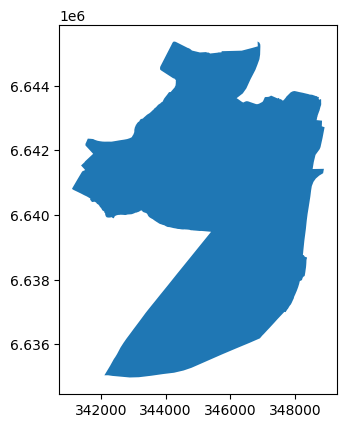

In [ ]:
spb1.plot()

In [ ]:
loc_inside = gpd.sjoin(loc, spb1, predicate="within")

In [ ]:
map = loc_inside.explore(tiles="CartoDB positron")
loc_inside.explore(
    m=map,
    color="purple")

# **3. Diversity indexes**

##Richness

In [ ]:
def richness(group):
    return group['type'].nunique()

## Berger Parker

In [ ]:
def berger_parker(group):
    proportions = group['type'].value_counts(normalize=True)
    return proportions.max()

## Shannon weiner

In [ ]:
def shannon_wiener_diversity(group):
    proportions = group['type'].value_counts(normalize=True)
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

# **5. Streets' uses diversity**

### Prelimenaries

In [ ]:

place = "Кировский район, Saint Petersburg, Russia"
area = ox.geocode_to_gdf(place)


In [ ]:
area

geometry  bbox_west  bbox_south  \
0  POLYGON ((30.16152 59.87428, 30.16152 59.87424...  30.161519   59.822573   

   bbox_east  bbox_north   place_id  osm_type   osm_id        lat        lon  \
0  30.300015    59.91726  157084952  relation  1114809  59.869887  30.234447   

      class            type  place_rank  importance     addresstype  \
0  boundary  administrative          10    0.439342  administrative   

                name                                       display_name  
0  Kirovsky District  Kirovsky District, округ Дачное, округ Ульянка...

In [ ]:
#loading the street-network (prefferably - segments' map with space syntax measures)
streets = gpd.read_file("/content/axee.shp")



In [ ]:
streets.explore()

In [ ]:
streets = streets.to_crs(epsg=32636)

## Streets Use Diversity analysis

### preparation

In [ ]:
streets["buffer1"] = streets.buffer(85)

In [ ]:
streets_n = streets.set_geometry("buffer1")

In [ ]:
locations_in_buffer = gpd.sjoin(loc, streets_n, how='inner', predicate='intersects')

<Axes: >

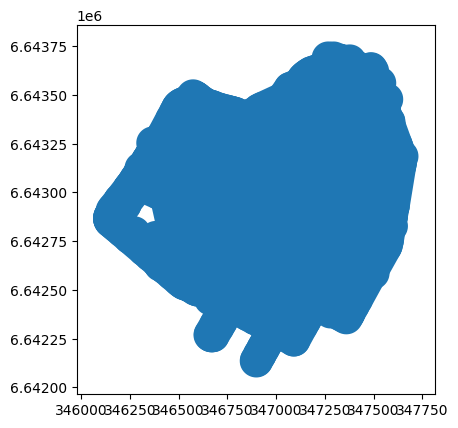

In [ ]:
streets["buffer1"].plot()

### 1. Richness

In [ ]:
richness_pb = locations_in_buffer.groupby('geometry_right').apply(richness)
streets_diversity_richness = streets_n.merge(richness_pb.rename('richness'), left_on= "geometry", right_on= "geometry_right", how = "left")

/tmp/ipython-input-2834420655.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  richness_pb = locations_in_buffer.groupby('geometry_right').apply(richness)


In [ ]:
streets_diversity_richness.head()

ref             x1            y1             x2            y2   angCONN  \
0    0  346291.232106  6.643044e+06  346297.486780  6.643042e+06  4.078338   
1    1  346297.486780  6.643042e+06  346406.271572  6.642993e+06  3.029243   
2    2  346406.271572  6.642993e+06  346437.170750  6.642978e+06  2.046286   
3    3  347072.043711  6.642641e+06  347074.352901  6.642632e+06  4.042369   
4    4  347074.352901  6.642632e+06  347092.201878  6.642563e+06  3.033646   

   axCONN  axid       axLEN  axref  CONN      segLEN        CH         INT  \
0       6     1    6.890466      0     6    6.890466  145844.0  1037.07150   
1       5     2  119.311470      1     5  119.311470  162037.0  1036.96680   
2       4     3   34.110695      2     4   34.110695  169074.0  1038.83130   
3       5     4    9.219479      3     5    9.219478  108591.0   847.16010   
4       5     5   71.178108      4     5   71.178108  106043.0   844.65131   

     NC         TD                                           geometry  \
0  3381  11022.539  LINESTRING (346291.232 6643044.411, 346297.487...   
1  3381  11023.652  LINESTRING (346297.487 6643041.52, 346406.272 ...   
2  3381  11003.867  LINESTRING (346406.272 6642992.519, 346437.171...   
3  3381  13493.508  LINESTRING (347072.044 6642641.283, 347074.353...   
4  3381  13533.586  LINESTRING (347074.353 6642632.357, 347092.202...   

                                             buffer1  richness  
0  POLYGON ((346333.149 6643118.677, 346340.54 66...       2.0  
1  POLYGON ((346441.181 6643070.019, 346448.609 6...       5.0  
2  POLYGON ((346473.177 6643055.067, 346480.55 66...       4.0  
3  POLYGON ((347156.643 6642653.647, 347158.334 6...       3.0  
4  POLYGON ((347174.486 6642584.768, 347176.179 6...       4.0

In [ ]:
streets_diversity_richness = streets_diversity_richness.set_geometry("geometry")

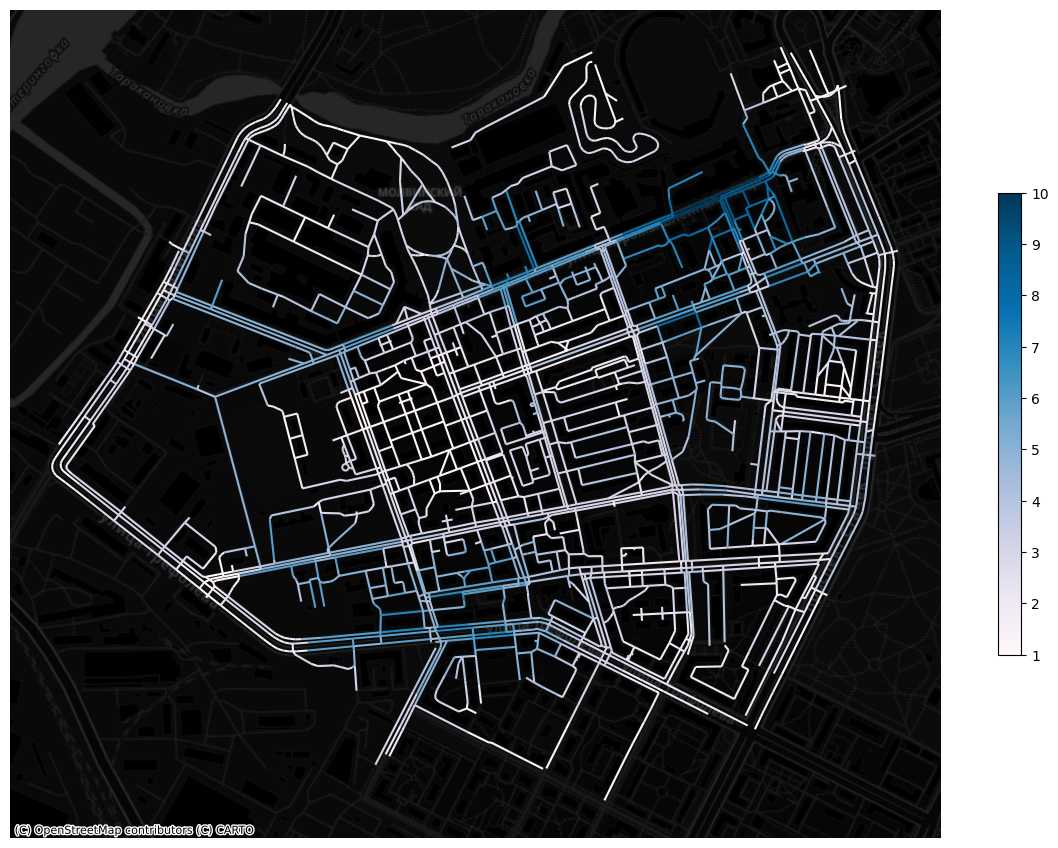

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

streets_diversity_richness1 = streets_diversity_richness.to_crs(epsg=3857)
streets_diversity_richness1.plot(column='richness', cmap='PuBu', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

### 3. Berger-Parker Abundance

In [ ]:
berger_parker_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(berger_parker)
streets_berger_parker_diversity = streets_n.merge(berger_parker_diversity_pb.rename('berger_parker'), left_on= "geometry", right_on= "geometry_right", how = "left")

/tmp/ipython-input-3332225726.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  berger_parker_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(berger_parker)


In [ ]:
streets_berger_parker_diversity = streets_berger_parker_diversity.set_geometry("geometry")

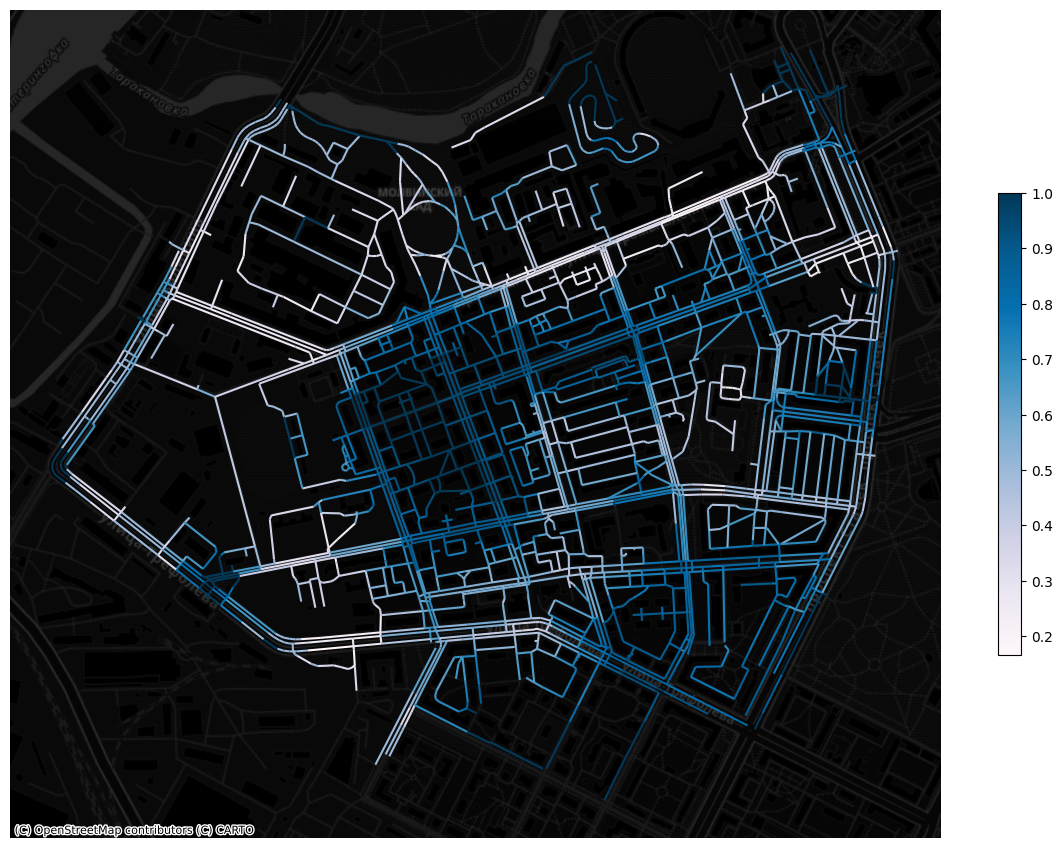

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

streets_berger_parker_diversity1 = streets_berger_parker_diversity.to_crs(epsg=3857)
streets_berger_parker_diversity1.plot(column='berger_parker', cmap='PuBu', legend=True, ax=ax,  legend_kwds={"shrink": 0.4})

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

In [ ]:
streets_berger_parker_diversity.explore(column = "berger_parker").save("aparts_berger_parker_diversity_map.html")

### 5. Shannon wiener

In [ ]:
shannon_wiener_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_diversity)
streets_shannon_wiener_diversity = streets_n.merge(shannon_wiener_diversity_pb.rename('shannon wiener'), left_on= "geometry", right_on= "geometry_right", how = "left")

/tmp/ipython-input-4165098873.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon_wiener_diversity_pb = locations_in_buffer.groupby('geometry_right').apply(shannon_wiener_diversity)


In [ ]:
streets_shannon_wiener_diversity = streets_shannon_wiener_diversity.set_geometry("geometry")

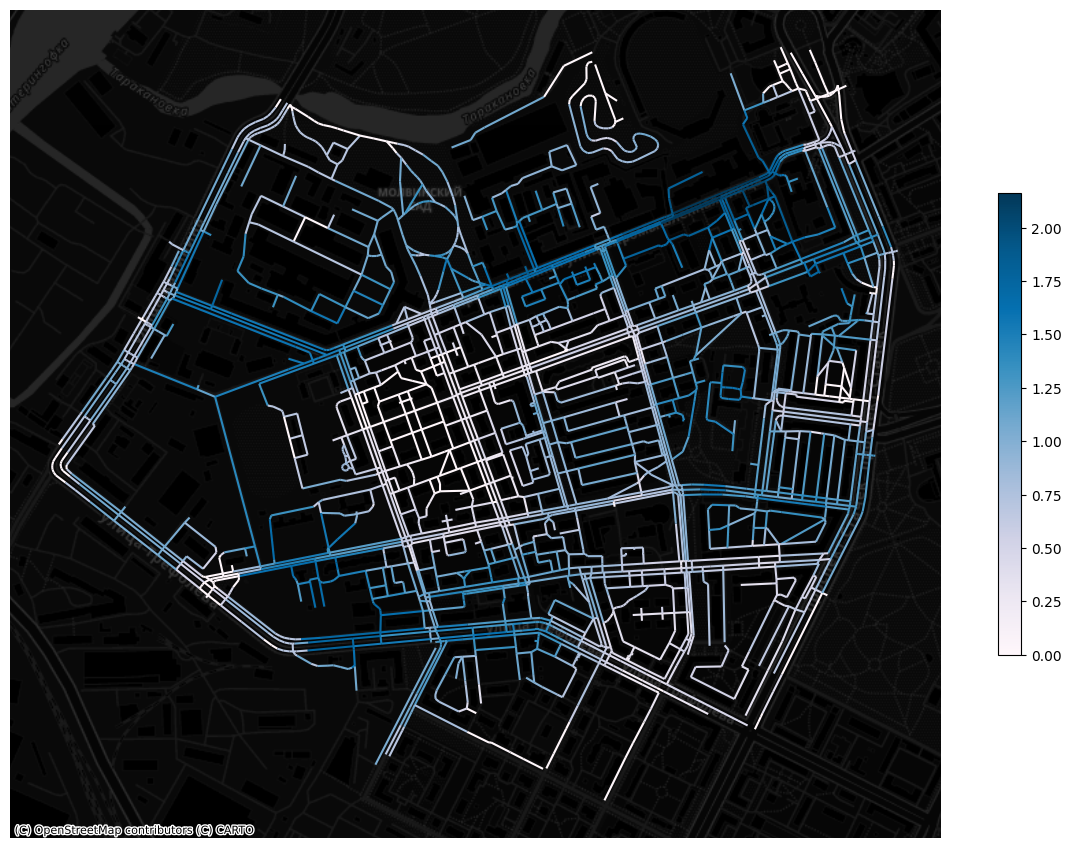

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

streets_shannon_wiener_diversity1 = streets_shannon_wiener_diversity.to_crs(epsg=3857)
streets_shannon_wiener_diversity1.plot(
    column='shannon wiener',
    cmap='PuBu',
    legend=True,
    ax=ax,
    legend_kwds={"shrink": 0.4}
)

cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
ax.set_axis_off()


### Merged dataset of diversity indexes

In [ ]:
streets_diversity = streets_n

In [ ]:
streets_diversity = streets_diversity.merge(richness_pb.rename('richness'), left_on= "geometry", right_on= "geometry_right", how = "left")

streets_diversity = streets_diversity.merge(berger_parker_diversity_pb.rename('berger_parker'), left_on= "geometry", right_on= "geometry_right", how = "left")

streets_diversity = streets_diversity.merge(shannon_wiener_diversity_pb.rename('shannon wiener'), left_on= "geometry", right_on= "geometry_right", how = "left")



streets_diversity = streets_diversity.set_geometry("geometry")

In [ ]:
streets_diversity.head()

ref             x1            y1             x2            y2   angCONN  \
0    0  346291.232106  6.643044e+06  346297.486780  6.643042e+06  4.078338   
1    1  346297.486780  6.643042e+06  346406.271572  6.642993e+06  3.029243   
2    2  346406.271572  6.642993e+06  346437.170750  6.642978e+06  2.046286   
3    3  347072.043711  6.642641e+06  347074.352901  6.642632e+06  4.042369   
4    4  347074.352901  6.642632e+06  347092.201878  6.642563e+06  3.033646   

   axCONN  axid       axLEN  axref  ...      segLEN        CH         INT  \
0       6     1    6.890466      0  ...    6.890466  145844.0  1037.07150   
1       5     2  119.311470      1  ...  119.311470  162037.0  1036.96680   
2       4     3   34.110695      2  ...   34.110695  169074.0  1038.83130   
3       5     4    9.219479      3  ...    9.219478  108591.0   847.16010   
4       5     5   71.178108      4  ...   71.178108  106043.0   844.65131   

     NC         TD                                           geometry  \
0  3381  11022.539  LINESTRING (346291.232 6643044.411, 346297.487...   
1  3381  11023.652  LINESTRING (346297.487 6643041.52, 346406.272 ...   
2  3381  11003.867  LINESTRING (346406.272 6642992.519, 346437.171...   
3  3381  13493.508  LINESTRING (347072.044 6642641.283, 347074.353...   
4  3381  13533.586  LINESTRING (347074.353 6642632.357, 347092.202...   

                                             buffer1 richness  berger_parker  \
0  POLYGON ((346333.149 6643118.677, 346340.54 66...      2.0       0.600000   
1  POLYGON ((346441.181 6643070.019, 346448.609 6...      5.0       0.375000   
2  POLYGON ((346473.177 6643055.067, 346480.55 66...      4.0       0.571429   
3  POLYGON ((347156.643 6642653.647, 347158.334 6...      3.0       0.500000   
4  POLYGON ((347174.486 6642584.768, 347176.179 6...      4.0       0.571429   

   shannon wiener  
0        0.673012  
1        1.494175  
2        1.153742  
3        0.898205  
4        1.046630  

[5 rows x 21 columns]

In [ ]:
streets_diversity1 = streets_diversity[[ "geometry", "buffer1", "richness", "shannon wiener","berger_parker", "INT", "CH"]]

In [ ]:
streets_diversity1.iloc[1]

geometry          LINESTRING (346297.48678 6643041.51974, 346406...
buffer1           POLYGON ((346441.18090033054 6643070.019332873...
richness                                                        5.0
shannon wiener                                             1.494175
berger_parker                                                 0.375
INT                                                       1036.9668
CH                                                         162037.0
Name: 1, dtype: object

In [ ]:
streets_diversity1.to_parquet("socio-spatial_morphology.gpkg")

In [ ]:
streets_diversity1.to_parquet("socio-spatial_morphology1.csv")

Shannon-Wiener Equity (Evenness) is misleading since the richness is low



# **6. Results Visualisation**

In [ ]:
streets_diversity2 = streets_diversity[[ "geometry", "richness", "berger_parker", "shannon wiener" ]]

In [ ]:
streets_diversity2 = streets_diversity2.dropna(axis = 0)

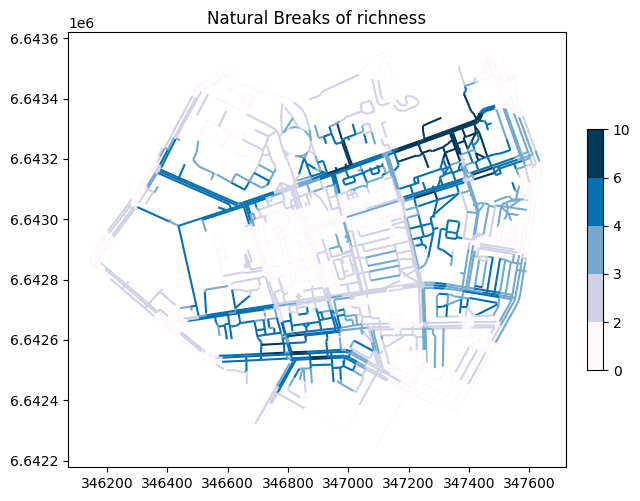

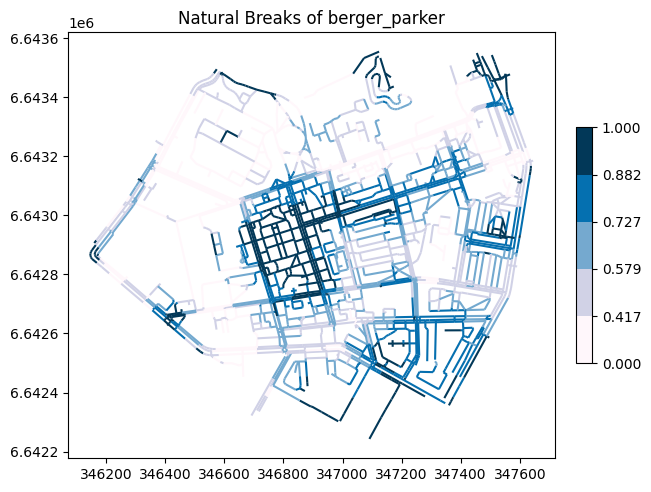

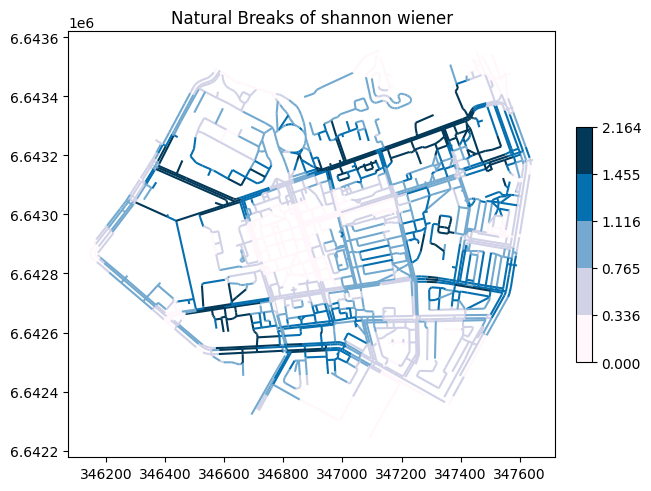

In [ ]:
for col in streets_diversity2.select_dtypes(include='number').columns:
    plt.figure(figsize=(12, 12))


    classifier = mapclassify.NaturalBreaks(streets_diversity2[col], k=5)
    streets_diversity2['nb_class'] = classifier.yb

    ax = plt.subplot(1, 2, 2)


    streets_diversity2.plot(
        column='nb_class',
        cmap='PuBu',
        legend=False,
        ax=ax
    )
    plt.title(f'Natural Breaks of {col}')


    bounds = list(classifier.bins)
    bounds = [streets_diversity2['nb_class'].min()] + bounds
    norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)


    sm = matplotlib.cm.ScalarMappable(cmap='PuBu', norm=norm)
    sm.set_array([])


    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=0.03,
        pad=0.04,
        aspect=15,
        shrink=0.5
    )


    plt.tight_layout()
    plt.savefig(f'{col} Natural Breaks.png', dpi=300, bbox_inches='tight')
plt.show()

# **7. Descriptive stats**

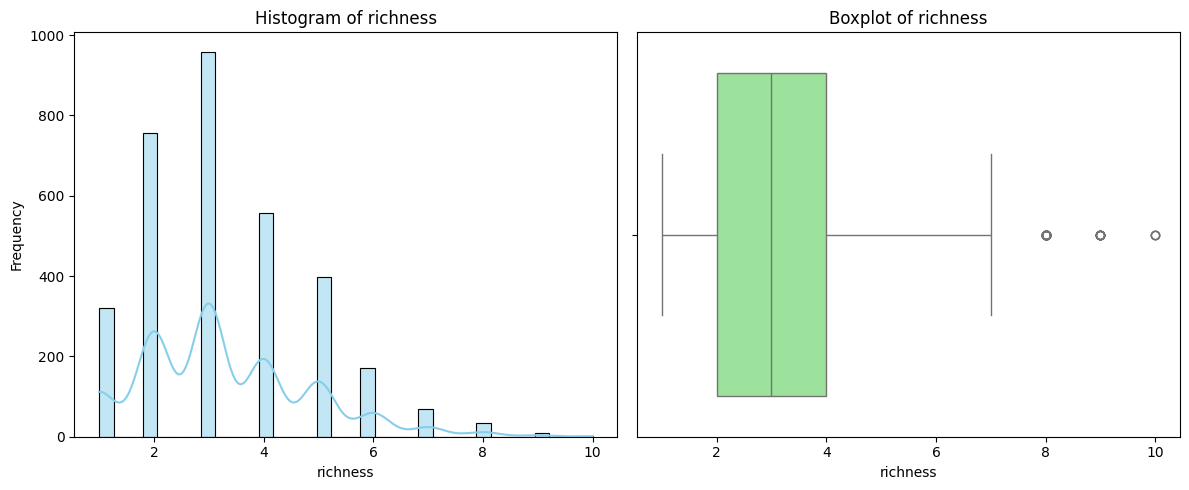

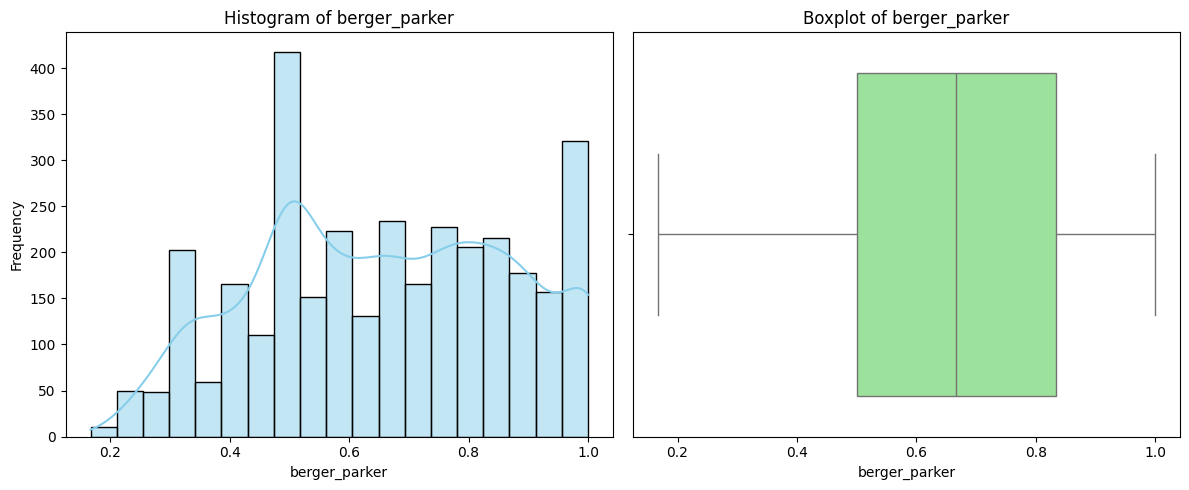

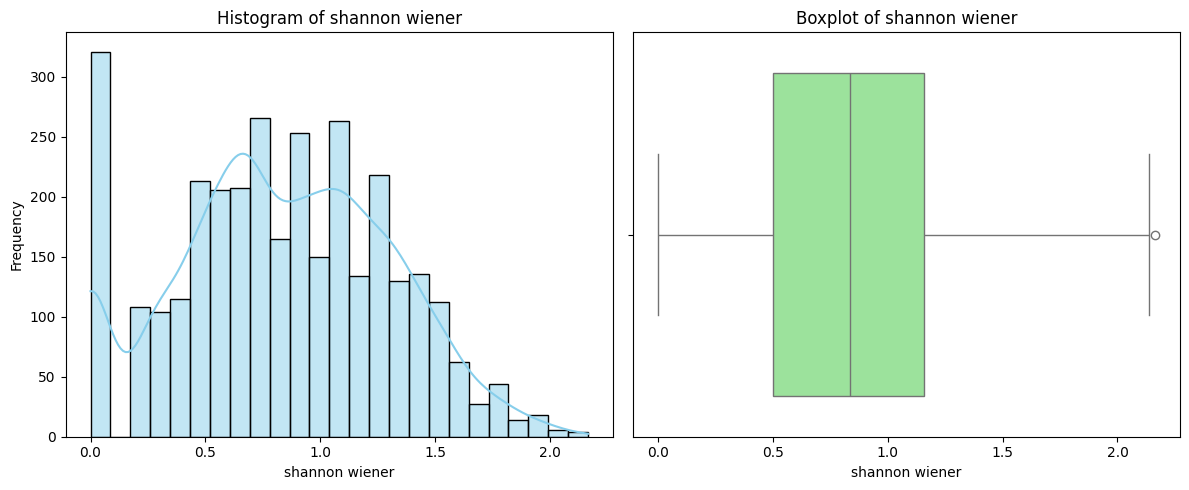

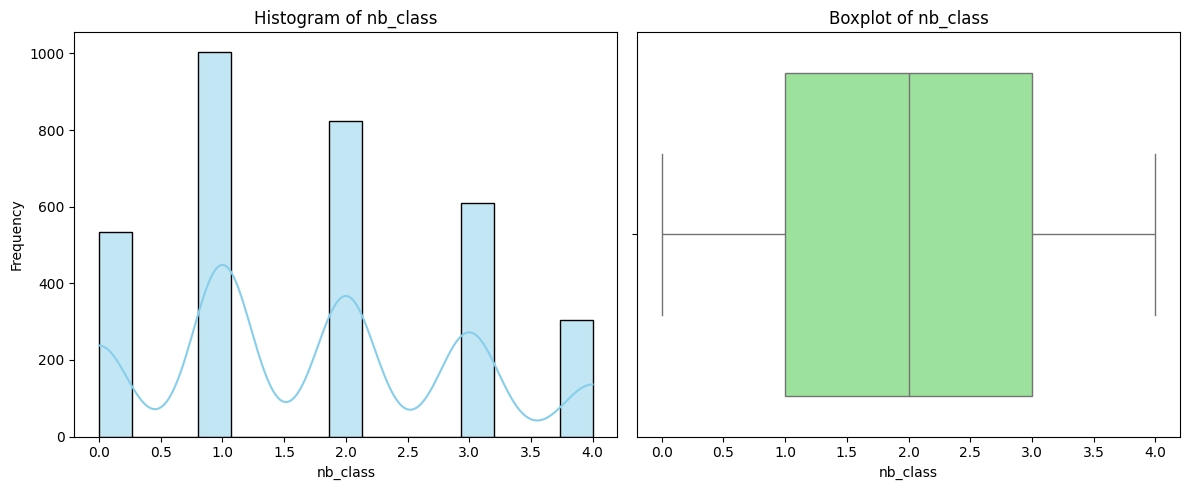

In [ ]:
for col in streets_diversity2.select_dtypes(include='number').columns:
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.histplot(streets_diversity2[col], kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')


    plt.subplot(1, 2, 2)
    sns.boxplot(x=streets_diversity2[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()

    plt.savefig(f'{col}descriptive statistics.png', dpi=300, bbox_inches='tight')

    plt.show()



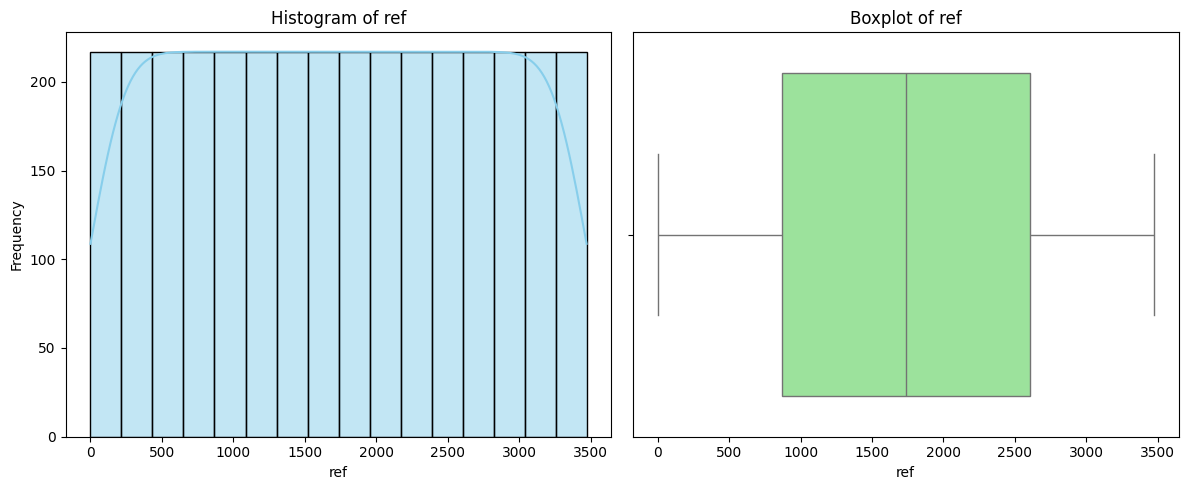

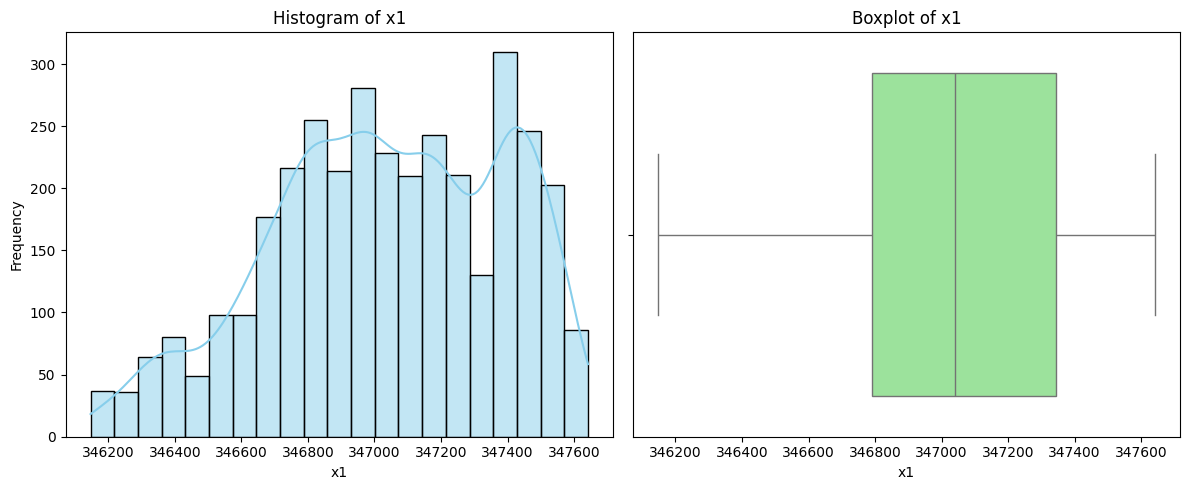

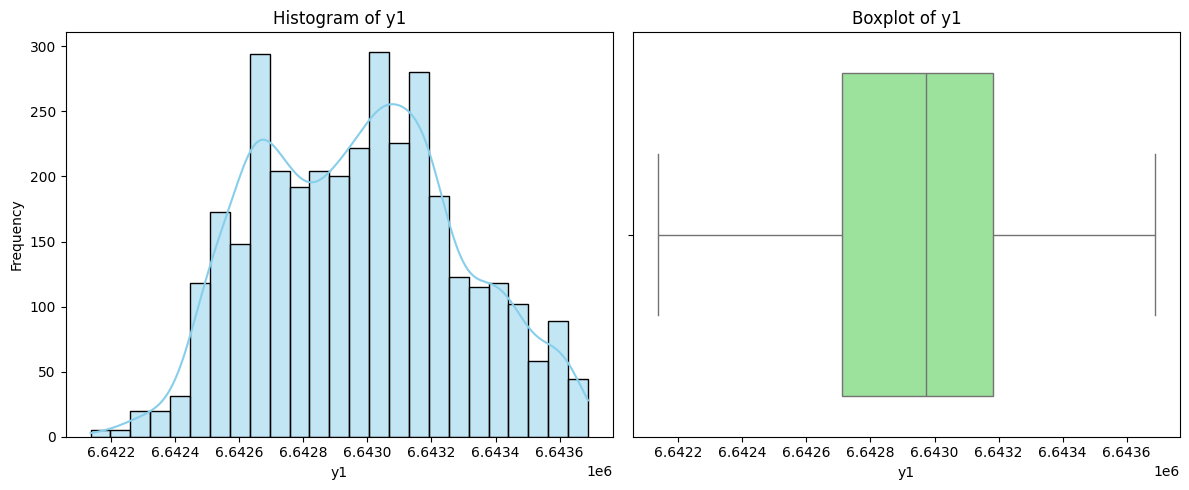

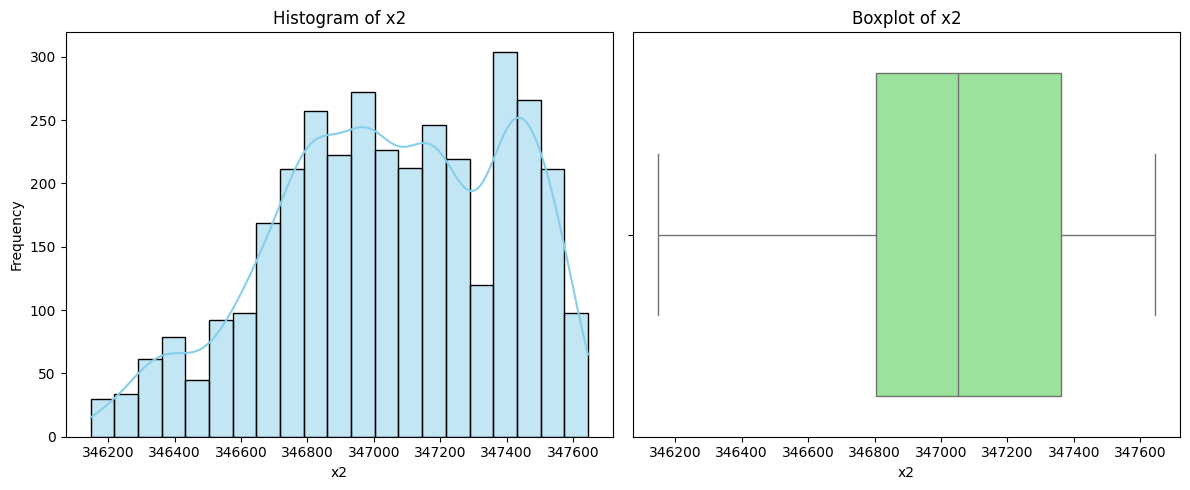

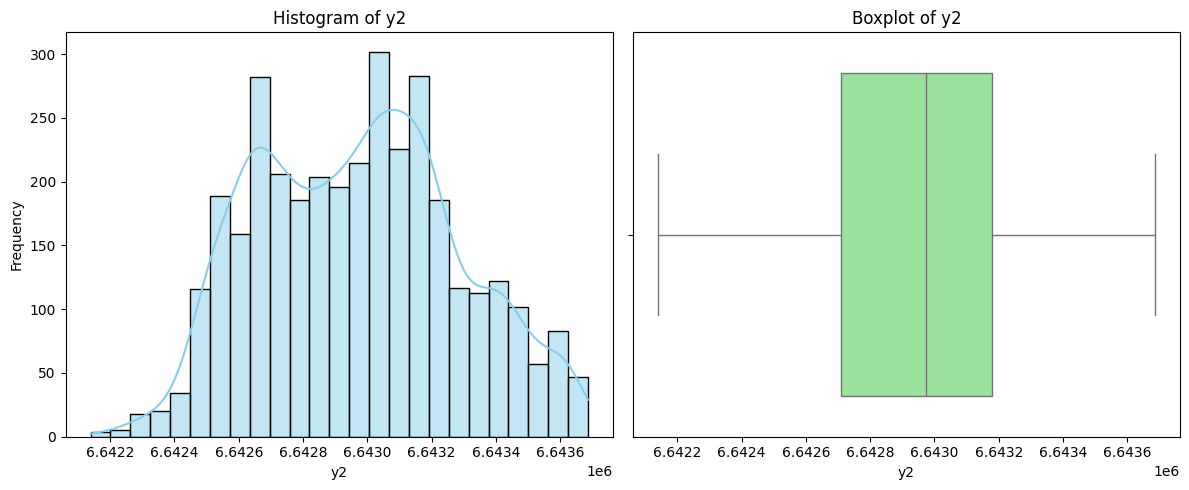

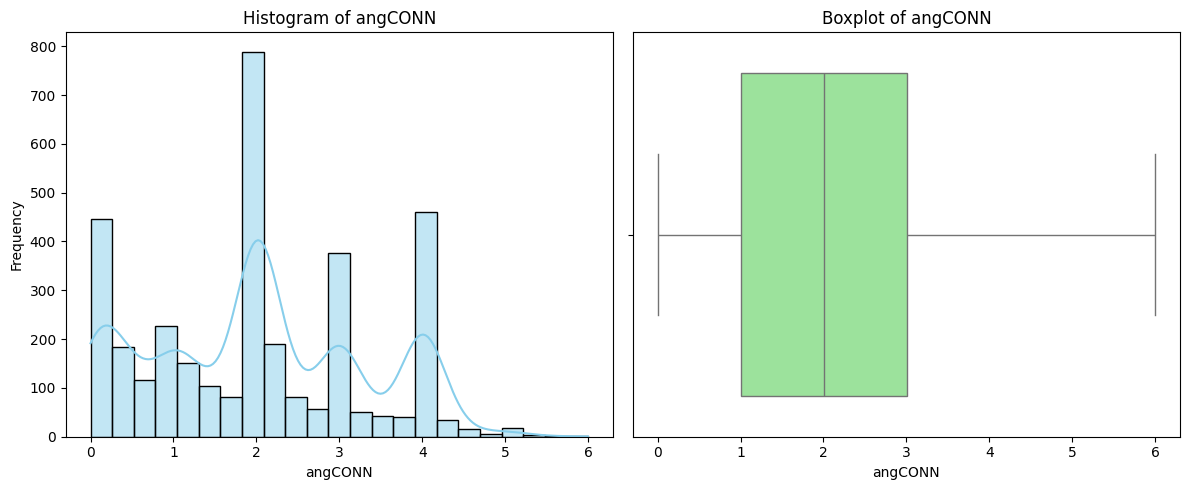

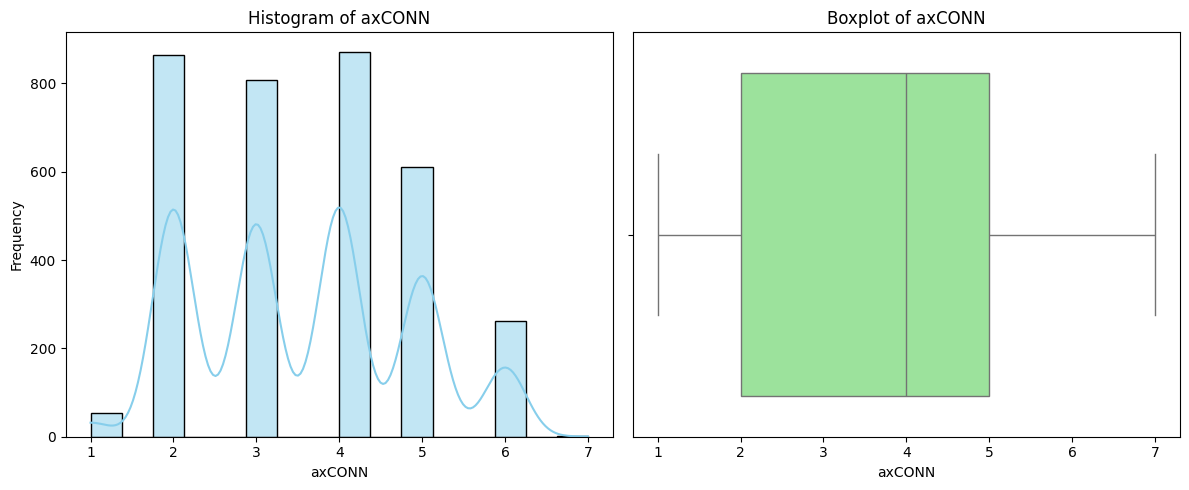

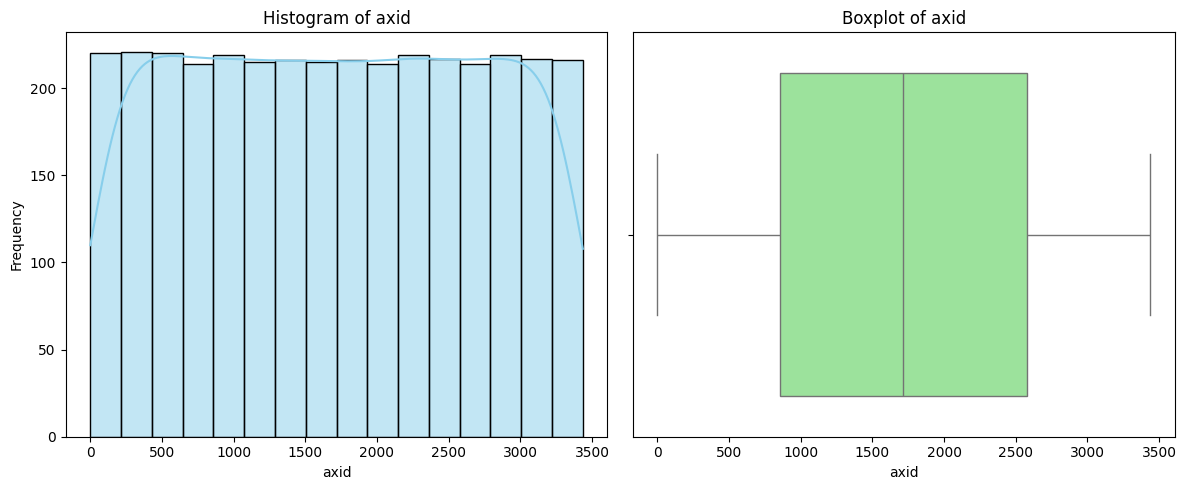

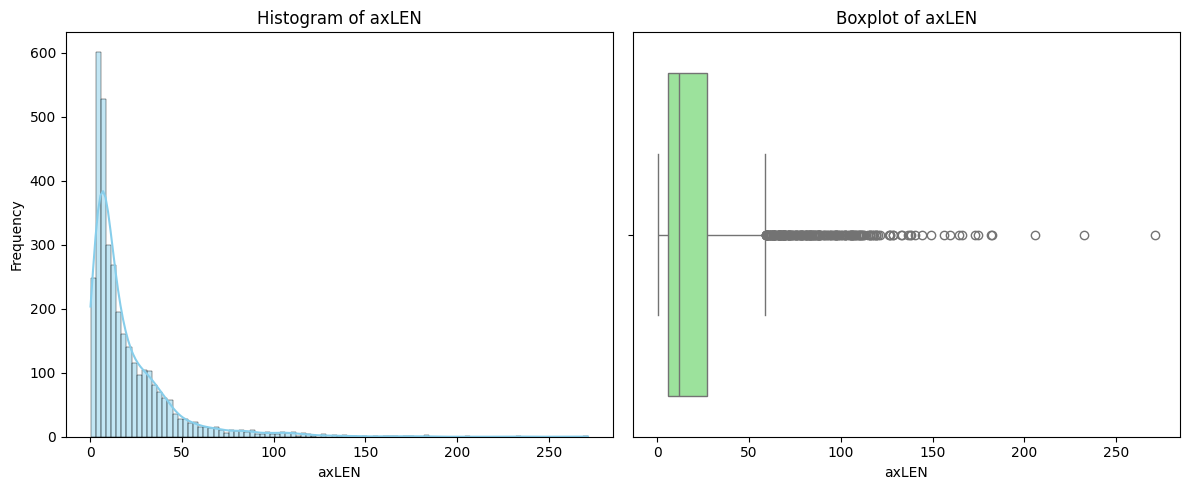

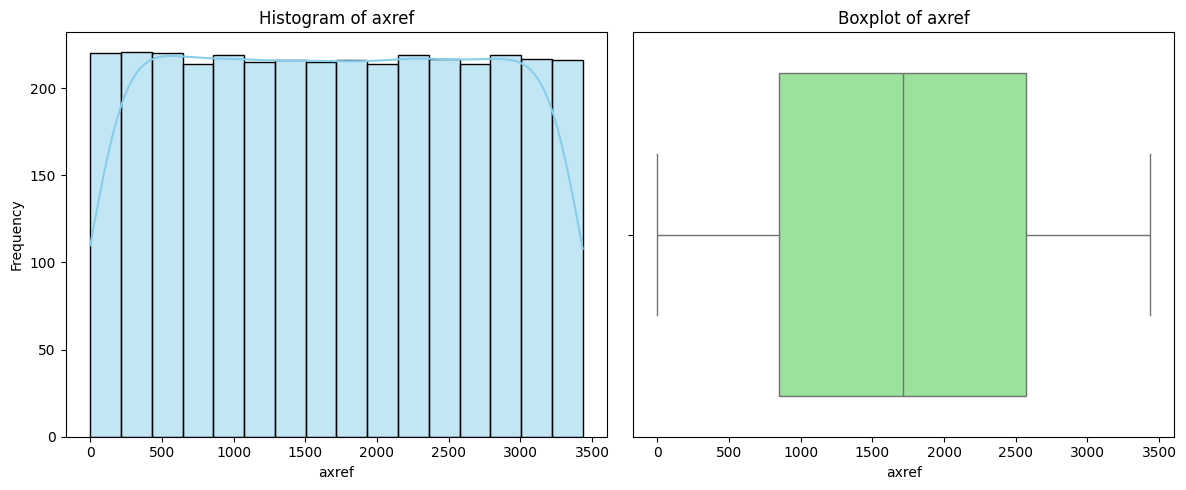

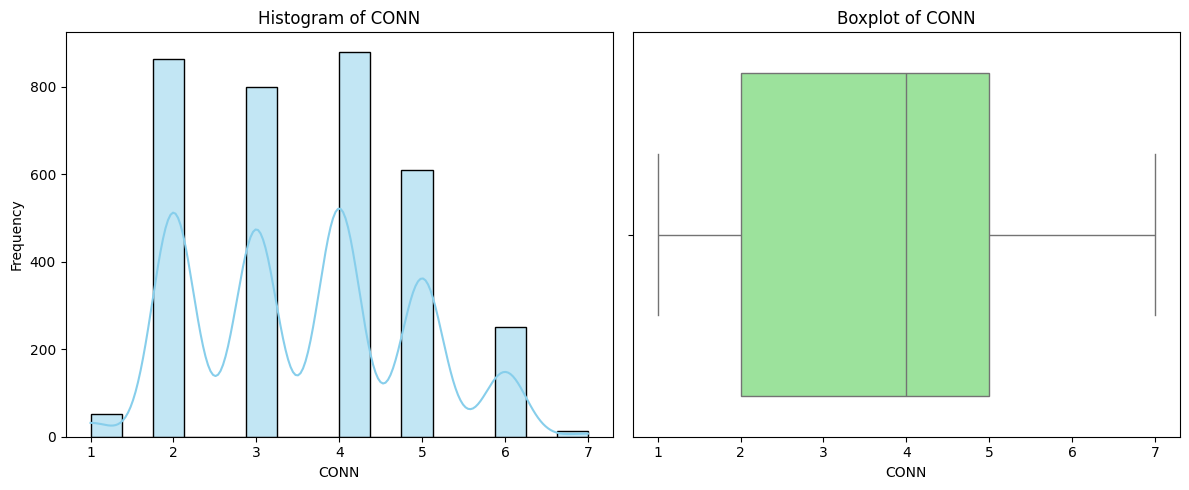

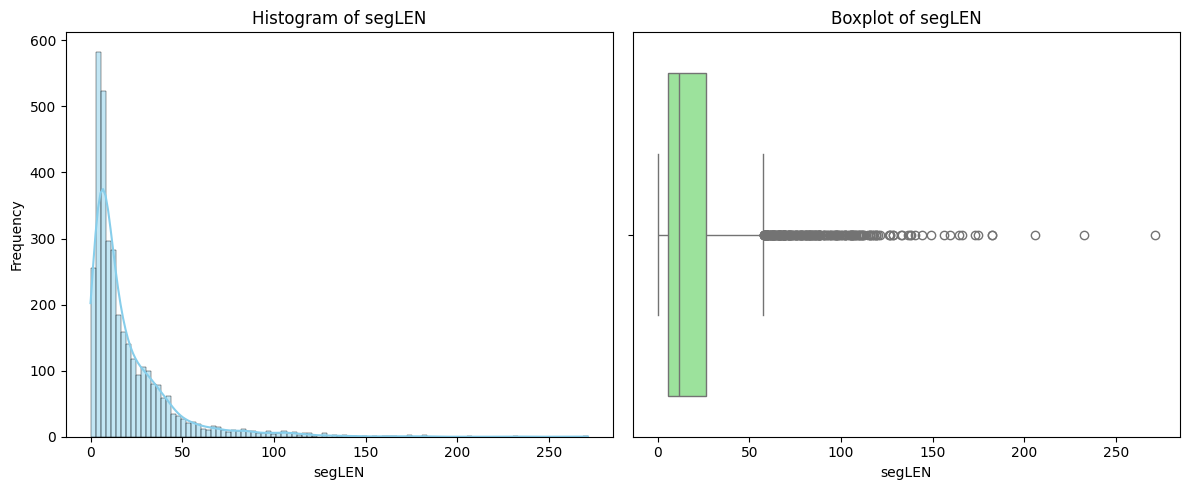

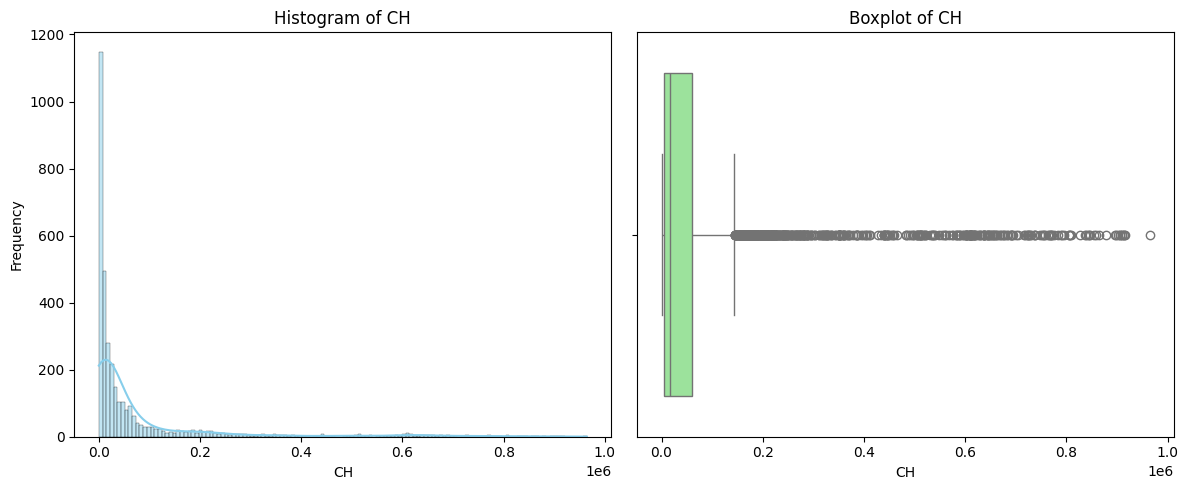

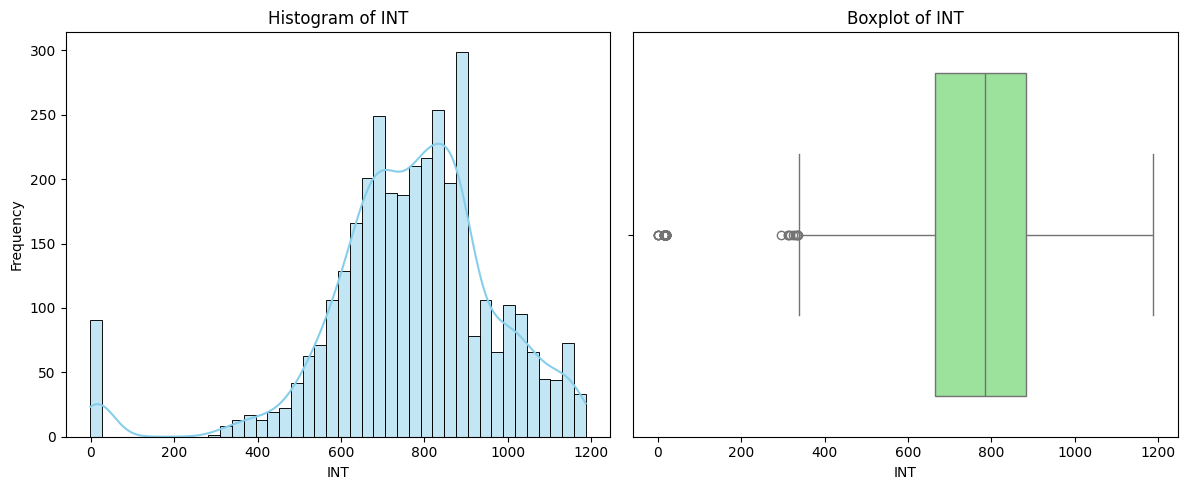

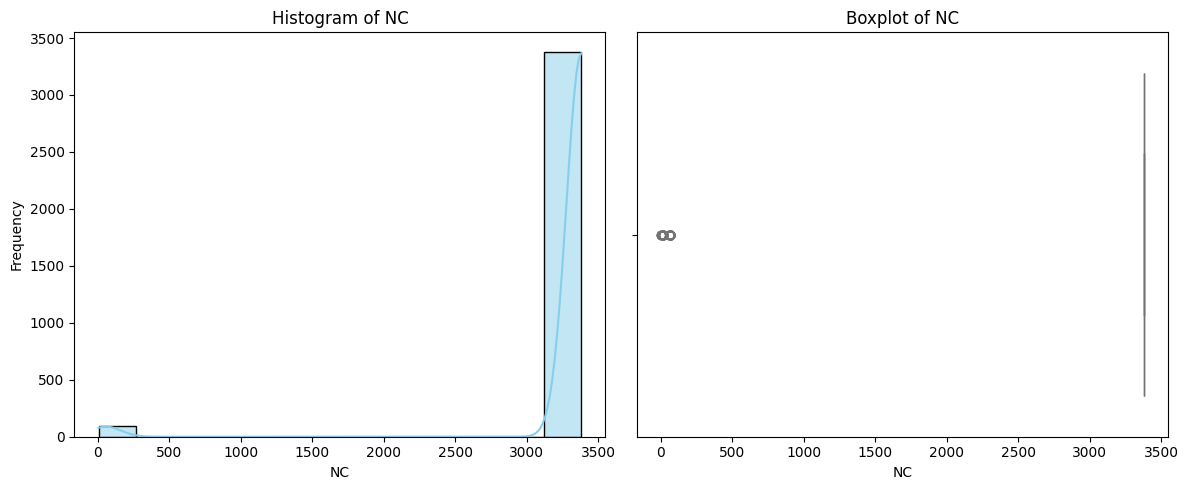

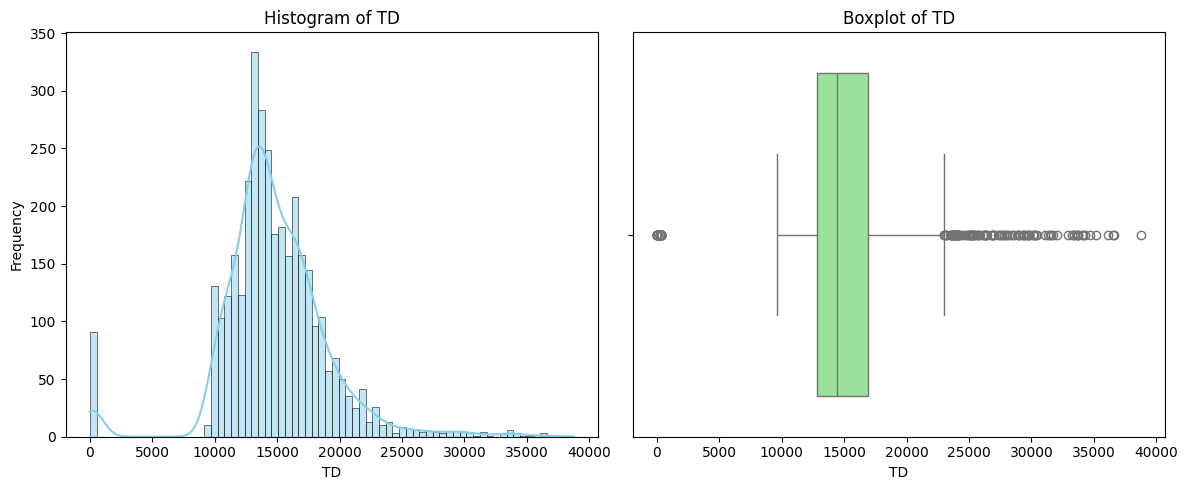

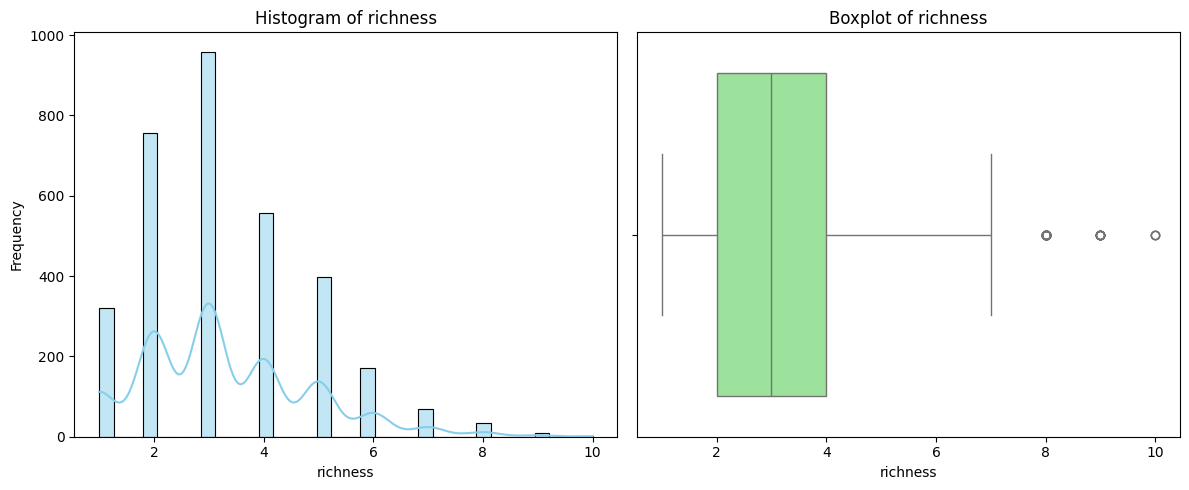

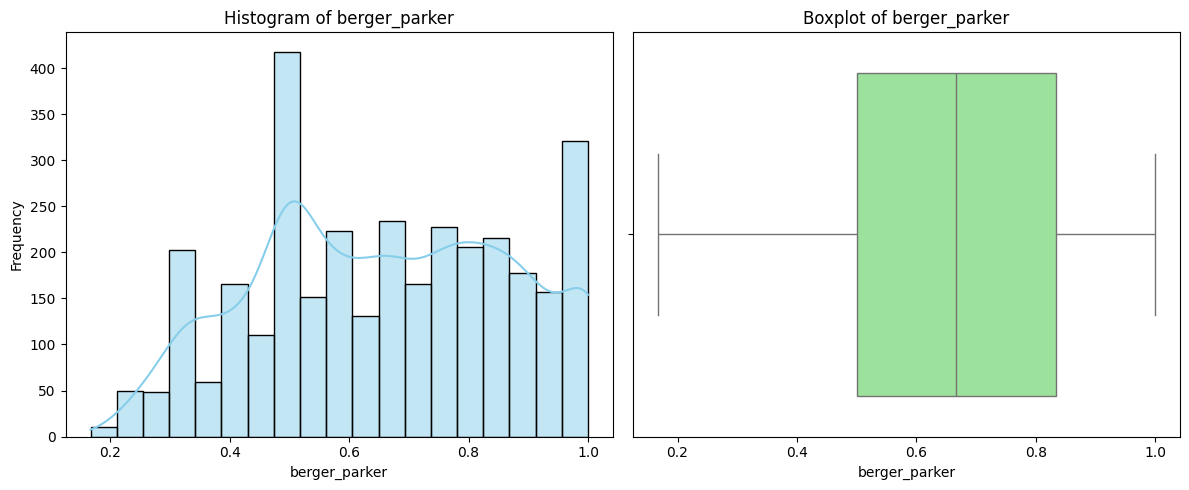

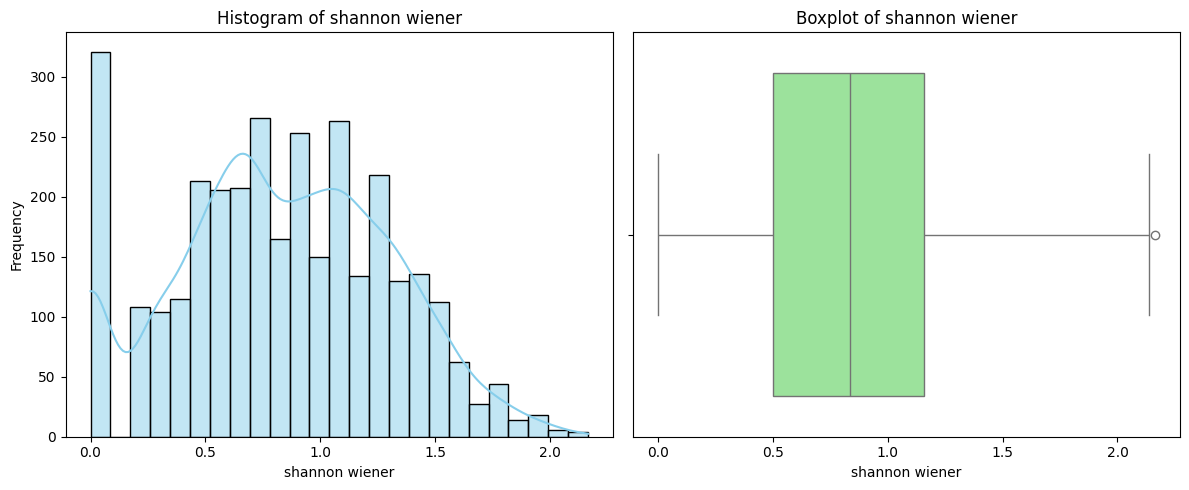

In [ ]:
for col in streets_diversity.select_dtypes(include='number').columns:
    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.histplot(streets_diversity[col], kde=True, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')


    plt.subplot(1, 2, 2)
    sns.boxplot(x=streets_diversity[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()

    plt.savefig(f'{col}descriptive statistics.png', dpi=300, bbox_inches='tight')

    plt.show()
